#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

#### Load Photos

Augmentation, normalization and transformation for train data:

In [3]:
data_transforms = transforms.Compose([
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), 
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.1),
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

Transformation and normalization for test/split data:

In [4]:
test_val_transforms = transforms.Compose([
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Read images from folders and put them in dataset:

In [5]:
train_dataset = datasets.ImageFolder(root='data/split_dataset/train', transform=data_transforms)
val_dataset = datasets.ImageFolder(root='data/split_dataset/val', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root='data/split_dataset/test', transform=test_val_transforms)

data-loader:

In [6]:
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Loading a pre-trained model.

I will use ResNet18 model

In [72]:
model = models.resnet18(pretrained=True)

Setting the number of output classes.
To speed up the training process, I put one FC

In [73]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),  
    nn.Linear(model.fc.in_features, 11)
)

Model params

In [74]:
criterion = nn.CrossEntropyLoss()

Optimizer

In [75]:
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': [param for name, param in model.named_parameters() if param.requires_grad and 'fc' not in name], 'lr': 1e-4}
])

#### Conducting model retraining

To freeze all layers in pretrained model:

In [76]:
for param in model.parameters():
    param.requires_grad = False

Unfreeze the final FC layer

In [77]:
for param in model.fc.parameters():
    param.requires_grad = True

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Model training function

In [80]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)

    defrost_layers = ['layer4', 'layer3']

    for epoch in range(num_epochs):
        if epoch < len(defrost_layers):
            layer_to_unfreeze = defrost_layers[epoch]
            print(f"Unfreezing: {layer_to_unfreeze}")
            for name, param in model.named_parameters():
                if layer_to_unfreeze in name:
                    param.requires_grad = True

        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct_train / total_train * 100

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct / total * 100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")


In [81]:
train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Unfreezing: layer4
Epoch 1/5: Train Loss = 0.8593, Train Accuracy = 71.83%, Val Loss = 0.4380, Val Accuracy = 85.81%
Unfreezing: layer3
Epoch 2/5: Train Loss = 0.3881, Train Accuracy = 87.15%, Val Loss = 0.3685, Val Accuracy = 89.80%
Epoch 3/5: Train Loss = 0.3061, Train Accuracy = 89.32%, Val Loss = 0.3214, Val Accuracy = 90.09%
Epoch 4/5: Train Loss = 0.2539, Train Accuracy = 91.59%, Val Loss = 0.2626, Val Accuracy = 91.93%
Epoch 5/5: Train Loss = 0.2043, Train Accuracy = 93.52%, Val Loss = 0.3322, Val Accuracy = 90.09%


Save model state

In [88]:
#torch.save(model.state_dict(), 'models\\model3\\model3_state_dict.pth')
# torch.save({
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'train_accuracies': train_accuracies,
#         'val_accuracies': val_accuracies
#     },  'models\\model3\\training_history3.pth')

Download model state

In [10]:
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),  
    nn.Linear(model.fc.in_features, 11)
)

In [11]:
model.load_state_dict(torch.load("models\\model3\\model3_state_dict.pth"))
model = model.to(device)
model.eval()
print()

#### Analysis of model perfomance

Get predictions from the validation set

In [12]:
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

The names of 11 classes

In [13]:
class_names = val_dataset.classes

In [23]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

         dew       0.91      1.00      0.95       104
     fogsmog       0.88      1.00      0.93       127
       frost       0.83      0.67      0.74        72
       glaze       0.82      0.78      0.80        96
        hail       0.98      0.91      0.94        88
   lightning       1.00      0.98      0.99        57
        rain       0.91      0.95      0.93        79
     rainbow       0.97      0.97      0.97        35
        rime       0.91      0.90      0.90       174
   sandstorm       1.00      0.91      0.95       104
        snow       0.78      0.82      0.80        93

    accuracy                           0.90      1029
   macro avg       0.91      0.90      0.90      1029
weighted avg       0.90      0.90      0.90      1029



Classification Report showed significant improvement compared to my trained models.
However, I don't have a hundred percent result. Let's see which classes we classify worse

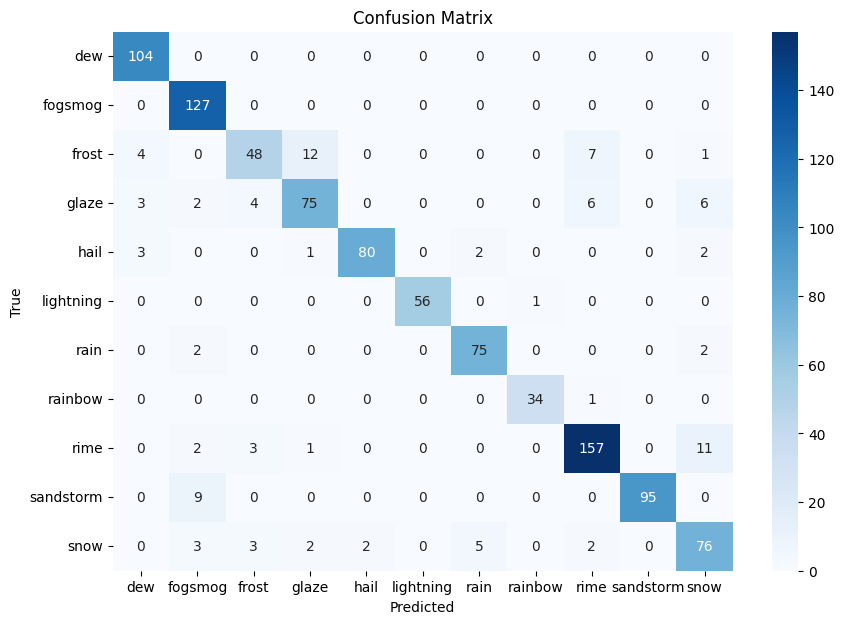

In [24]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

As we can see, the main problems occur with winter classes, namely:
frost (заморозки), glaze (льодова кірка), snow (снігопад), rime (іній)

In [14]:
model.eval()

misclassified_images = []
true_labels_misclassified = []
predicted_labels_misclassified = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_indices:
            misclassified_images.append(inputs[idx].cpu())
            true_labels_misclassified.append(labels[idx].cpu().item())
            predicted_labels_misclassified.append(predicted[idx].cpu().item())

In [15]:
def denormalize(img, mean, std):
    """Denormalize the image using mean and std."""
    mean = np.array(mean)
    std = np.array(std)
    img = img.numpy().transpose((1, 2, 0)) 
    img = img * std + mean 
    img = np.clip(img, 0, 1) 
    return img

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

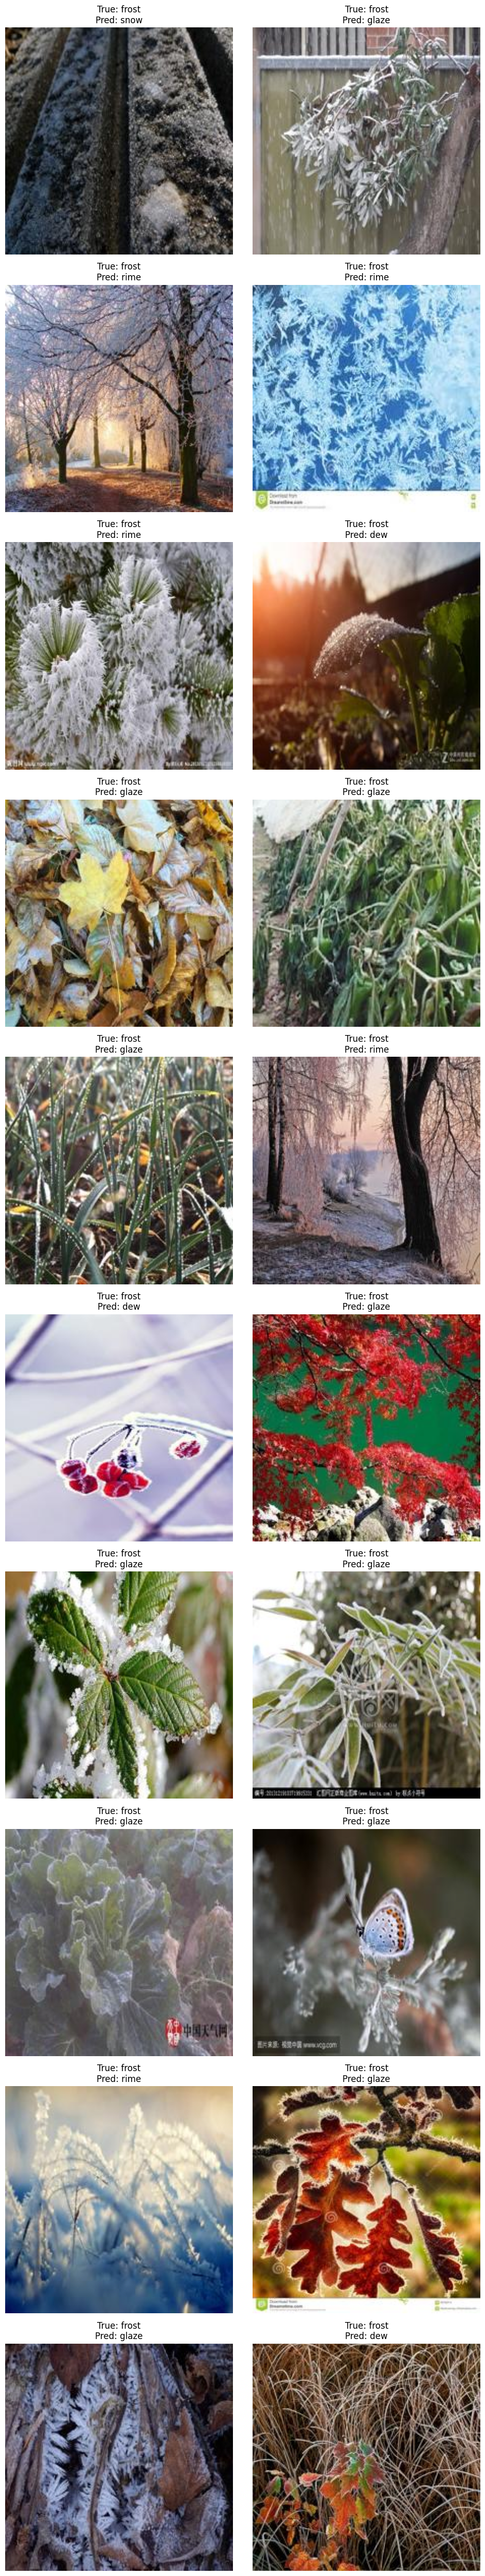

In [16]:
images_per_row = 2
num_images = min(len(misclassified_images), 20)  
rows = (num_images + images_per_row - 1) // images_per_row  

fig, axes = plt.subplots(rows, images_per_row, figsize=(10, rows * 5))
axes = axes.flatten()

for i in range(num_images):
    img = misclassified_images[i]
    img_denormalized = denormalize(img, mean, std)
    axes[i].imshow(img_denormalized)
    axes[i].set_title(f"True: {class_names[true_labels_misclassified[i]]}\n"
                      f"Pred: {class_names[predicted_labels_misclassified[i]]}")
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Аnd indeed winter classes are hard to distinguish for me too. They have visual similarity and overlapping features.

As for now i am satisfied with results. My model gives me precision of 73%, which is decent result for now.
In the future I could try balance number of classes. Also i could try Data Augmentation related to snow classes.
Increasing resolution could help too.